<a href="https://colab.research.google.com/github/PhateTarun/machine-learning/blob/master/credicxo_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install tensorflow-gpu

     |████████████████████████████████| 380.8MB 48kB/s 
     |████████████████████████████████| 450kB 46.7MB/s 
     |████████████████████████████████| 3.8MB 31.2MB/s 
     |████████████████████████████████| 81kB 14.1MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.8.2 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled goog

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Activation, Conv1D, Dropout, Flatten, LSTM
from tensorflow.keras.models import Model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.manifold import TSNE
from keras.utils import np_utils
from random import randint

import warnings
warnings.filterwarnings("ignore")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Using TensorFlow backend.


In [0]:
data = pd.read_csv('/content/drive/My Drive/musk_csv.csv')

### **What**'s in our Data

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6598 entries, 0 to 6597
Columns: 170 entries, ID to class
dtypes: int64(168), object(2)
memory usage: 8.6+ MB


    Finding if there are any null values in the data

In [5]:
null = data.isnull().any()
print("There are null values in the data set") if True in list(null) else print("There are no null values in the data")

There are no null values in the data


In [6]:
data.head(3)

,ID,molecule_name,conformation_name,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,...,f128,f129,f130,f131,f132,f133,f134,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,class
0,1,MUSK-211,211_1+1,46,-108,-60,-69,-117,49,38,-161,-8,5,-323,-220,-113,-299,-283,-307,-31,-106,-227,-42,-59,-22,-67,189,81,17,-27,-89,-67,105,-116,124,-106,5,-120,63,-165,...,81,-114,-187,45,-118,-75,-182,-234,-19,12,-13,-41,-119,-149,70,17,-20,-177,-101,-116,-14,-50,24,-81,-125,-114,-44,128,3,-244,-308,52,-7,39,126,156,-50,-112,96,1
1,2,MUSK-211,211_1+10,41,-188,-145,22,-117,-6,57,-171,-39,-100,-319,-111,-228,-281,-281,-300,54,-149,-98,-196,-27,-22,2,75,49,-34,45,-91,32,95,-116,85,-23,42,-58,61,-171,...,88,-21,-32,32,-128,-72,-124,-218,-94,53,-79,-20,-35,-26,4,50,17,-177,-102,-121,-66,-77,51,-41,-34,-32,-63,115,-5,-235,-59,-2,52,103,136,169,-61,-136,79,1
2,3,MUSK-211,211_1+11,46,-194,-145,28,-117,73,57,-168,-39,-22,-319,-111,-104,-283,-282,-303,52,-152,-97,-225,-28,-22,2,179,49,-33,46,-88,22,79,-116,19,-11,6,-38,71,-175,...,64,0,-23,-15,-129,-74,-125,-221,-93,53,-72,-19,-33,-26,3,49,17,-177,-102,-119,-66,-81,51,-41,-27,-41,-140,77,-163,-238,-134,-154,57,143,142,165,-67,-145,39,1


In [7]:
data.tail(3)

,ID,molecule_name,conformation_name,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,...,f128,f129,f130,f131,f132,f133,f134,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,class
6595,6596,NON-MUSK-jp13,jp13_2+7,44,-102,-19,-104,-117,72,-165,65,-219,-12,-107,-66,-58,-82,-77,-288,-214,-21,-58,-32,-93,-183,-197,-71,218,-217,-164,-161,-59,243,-117,-103,-14,118,-157,140,-150,...,167,-13,-188,-89,-117,-57,-47,-33,-28,-175,-50,-216,-129,-130,-138,-155,-169,-178,-102,-124,-32,-51,-136,-98,-123,-112,-55,-47,-84,-226,90,117,-8,150,130,159,-66,-144,-6,0
6596,6597,NON-MUSK-jp13,jp13_2+8,51,-121,-23,-106,-117,63,-161,79,-224,-30,-129,-54,-60,-86,-88,-307,-221,-39,-58,-12,-86,-184,-180,-61,221,-211,-168,-154,-63,243,-107,136,-121,116,-122,73,-155,...,167,7,-170,43,-6,-61,-47,-43,-23,-176,-33,-212,-131,-113,-139,-153,-170,-178,-103,-114,-42,-66,-141,-96,-123,-113,-46,124,-11,-238,86,99,-14,-31,106,171,-44,-116,117,0
6597,6598,NON-MUSK-jp13,jp13_2+9,51,-122,-23,-106,-117,190,-161,80,-227,-52,-139,-63,-51,-79,-99,-122,-220,-35,-57,6,-104,-183,-196,-51,63,-204,-169,-154,63,128,-108,135,-121,42,-122,73,-90,...,98,-57,-152,43,-4,-69,-51,-37,-23,-175,-33,-209,-108,-125,-139,-153,-170,-178,-102,-115,-42,-66,-141,-96,-110,-113,-46,124,-11,95,40,124,-14,-30,107,171,-44,-115,118,0


    based on the above data we can observe that molecule_name is suffixed by the conformation name
    while conformation_name is sufffixed by the counting of the conformation_name
    We can separate the compound name from molecule name, and can get the conformation name from molecule_name itself 

In [8]:
compound_name = []
conformation_name = []
# extracting compound name and conformation name from molecule_name
for i in data['molecule_name'].tolist():
    temp  = i.split('-')
    compound_name.append(temp[0]) if len(temp)==2  else compound_name.append(temp[0]+' '+temp[1])
    conformation_name.append(temp[1]) if len(temp)==2 else conformation_name.append(temp[2])

print("Number of conformation names in the data = ", len(Counter(conformation_name)))
print("Number of compound names = ", len(Counter(compound_name)))

Number of conformation names in the data =  102
Number of compound names =  2


In [0]:
data['compound_name'] = compound_name
data['conformation_name'] = conformation_name

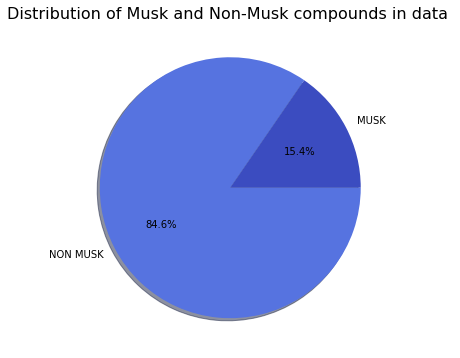

In [10]:
plt.figure(figsize=(6,6))
cmap = plt.get_cmap('coolwarm')
colors = [cmap(i) for i in np.linspace(0, 1, 12)]
n_compounds = Counter(compound_name)
plt.pie(list(n_compounds.values()), labels=list(n_compounds.keys()),autopct='%1.1f%%', shadow=True, colors=colors)
plt.title('Distribution of Musk and Non-Musk compounds in data ', fontsize=16)
plt.show()

    As we can observe above the data is pretty much imbalanced with non-musk compounds are 84.6% of the data while 
    musk compounds are just 15.4%

    It would be interesting to know aboud the two classes of data, if there are some common property b/w these two or not 

In [0]:
# dividing data into musk and non musk, to find out various properties of the data
musk = data.loc[data['compound_name']=='MUSK']
non_musk = data.loc[data['compound_name']=='NON MUSK']
class_ = data['class'].tolist()
data.drop(['class'], axis=1, inplace=True)

In [0]:
def bar_plot(data_dict,x_label='', y_label='',title='', size=[7,5], annot=False):
    plt.figure(figsize=(size[0], size[1]))
    x = list(data_dict.keys())
    y = list(data_dict.values())
    sns.set_style("darkgrid")
    ax = sns.barplot(x,y)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    try:
        int(x[0])
        plt.xticks(range(len(y)), sorted(x), rotation=40)
    except:
        plt.xticks(range(len(y)), x)
    if annot:
        for p  in (ax.patches) :
            ax.annotate( "%d" %(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=12, color='black', rotation=5, xytext=(0, 5),
                        textcoords='offset points')
    plt.grid()
    plt.title(title)

    plt.show()

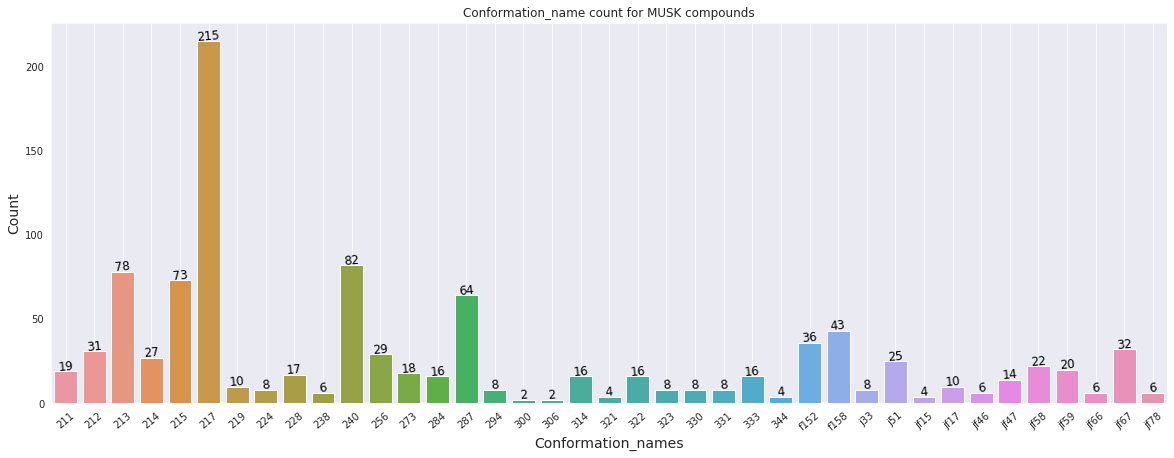

Total unique conformation names for MUSK compounds are =  39


In [13]:
x_label='Conformation_names'
y_label = 'Count'
title='Conformation_name count for MUSK compounds'
bar_plot(Counter(musk['conformation_name']),x_label=x_label, y_label=y_label, title=title, size=[20,7], annot=True)
print("Total unique conformation names for MUSK compounds are = ", len(Counter(musk['conformation_name'])))

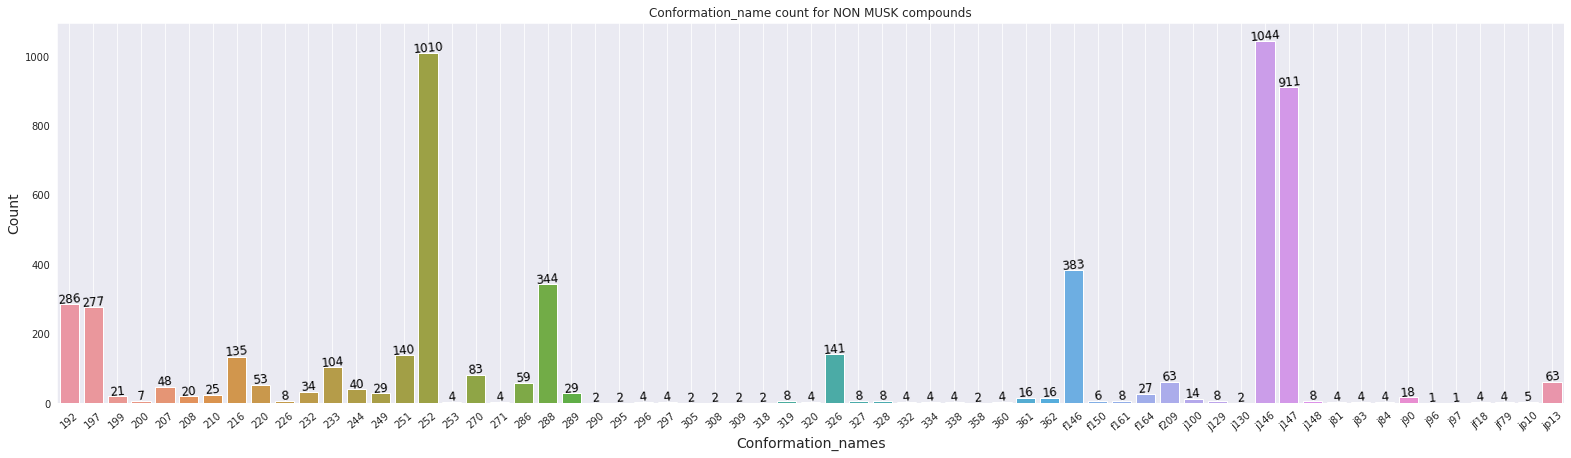

Total unique conformation names for NON MUSK compounds are =  63


In [14]:
title='Conformation_name count for NON MUSK compounds'
bar_plot(Counter(non_musk['conformation_name']),x_label=x_label, y_label=y_label, title=title, size=[27,7], annot=True)
print("Total unique conformation names for NON MUSK compounds are = ", len(Counter(non_musk['conformation_name'])))

    Looking at the above two bar plots for MUSK and NON MUSK compounds we can say that the conformation names are not very well 
    distributed b/w the two classes. Moreover both of compounds are not having common confomation names.

### Exploring **numerical** **features**

In [0]:
numeric_features = data.select_dtypes(include = [np.number])

In [16]:
numeric_features.head(3)

,ID,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,...,f127,f128,f129,f130,f131,f132,f133,f134,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166
0,1,46,-108,-60,-69,-117,49,38,-161,-8,5,-323,-220,-113,-299,-283,-307,-31,-106,-227,-42,-59,-22,-67,189,81,17,-27,-89,-67,105,-116,124,-106,5,-120,63,-165,40,-27,...,-27,81,-114,-187,45,-118,-75,-182,-234,-19,12,-13,-41,-119,-149,70,17,-20,-177,-101,-116,-14,-50,24,-81,-125,-114,-44,128,3,-244,-308,52,-7,39,126,156,-50,-112,96
1,2,41,-188,-145,22,-117,-6,57,-171,-39,-100,-319,-111,-228,-281,-281,-300,54,-149,-98,-196,-27,-22,2,75,49,-34,45,-91,32,95,-116,85,-23,42,-58,61,-171,2,-144,...,17,88,-21,-32,32,-128,-72,-124,-218,-94,53,-79,-20,-35,-26,4,50,17,-177,-102,-121,-66,-77,51,-41,-34,-32,-63,115,-5,-235,-59,-2,52,103,136,169,-61,-136,79
2,3,46,-194,-145,28,-117,73,57,-168,-39,-22,-319,-111,-104,-283,-282,-303,52,-152,-97,-225,-28,-22,2,179,49,-33,46,-88,22,79,-116,19,-11,6,-38,71,-175,3,-129,...,41,64,0,-23,-15,-129,-74,-125,-221,-93,53,-72,-19,-33,-26,3,49,17,-177,-102,-119,-66,-81,51,-41,-27,-41,-140,77,-163,-238,-134,-154,57,143,142,165,-67,-145,39


In [0]:
# removing ID from the features
numeric_features.drop(['ID'], axis=1, inplace=True)

In [18]:
numeric_features.head(3)

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,...,f127,f128,f129,f130,f131,f132,f133,f134,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166
0,46,-108,-60,-69,-117,49,38,-161,-8,5,-323,-220,-113,-299,-283,-307,-31,-106,-227,-42,-59,-22,-67,189,81,17,-27,-89,-67,105,-116,124,-106,5,-120,63,-165,40,-27,68,...,-27,81,-114,-187,45,-118,-75,-182,-234,-19,12,-13,-41,-119,-149,70,17,-20,-177,-101,-116,-14,-50,24,-81,-125,-114,-44,128,3,-244,-308,52,-7,39,126,156,-50,-112,96
1,41,-188,-145,22,-117,-6,57,-171,-39,-100,-319,-111,-228,-281,-281,-300,54,-149,-98,-196,-27,-22,2,75,49,-34,45,-91,32,95,-116,85,-23,42,-58,61,-171,2,-144,38,...,17,88,-21,-32,32,-128,-72,-124,-218,-94,53,-79,-20,-35,-26,4,50,17,-177,-102,-121,-66,-77,51,-41,-34,-32,-63,115,-5,-235,-59,-2,52,103,136,169,-61,-136,79
2,46,-194,-145,28,-117,73,57,-168,-39,-22,-319,-111,-104,-283,-282,-303,52,-152,-97,-225,-28,-22,2,179,49,-33,46,-88,22,79,-116,19,-11,6,-38,71,-175,3,-129,37,...,41,64,0,-23,-15,-129,-74,-125,-221,-93,53,-72,-19,-33,-26,3,49,17,-177,-102,-119,-66,-81,51,-41,-27,-41,-140,77,-163,-238,-134,-154,57,143,142,165,-67,-145,39


In [0]:
# Normalizig the numerical features
normalized_features = data.select_dtypes(include = [np.number])
normalized_features.drop(['ID'], axis=1, inplace=True)
for i in normalized_features.columns:
    feature  = normalized_features[i].tolist()
    max_ = max(feature)
    normalized_features[i] = [j/float(max_) for j in feature]

In [0]:
title_tsne_bow = TSNE(n_components=2, perplexity=150, learning_rate=5000) # perplexity is 150 learning rate is 5000
X_embedding = title_tsne_bow.fit_transform(numeric_features)

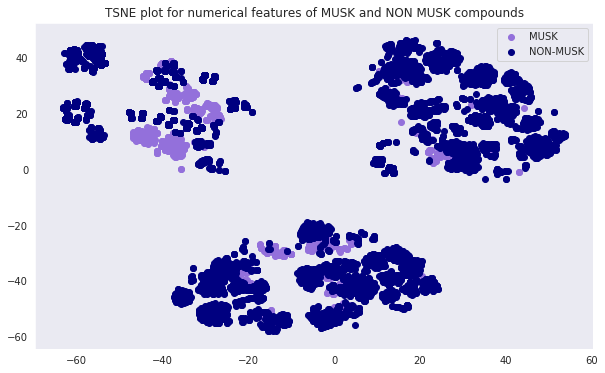

In [21]:
Musk = [i for i,j in zip(X_embedding, class_) if j==1]
Non_musk = [i for i,j in zip(X_embedding, class_) if j==0]
colors = {0:'navy', 1:'mediumpurple', 2:'green'}
plt.figure(figsize=(10,6))
plt.scatter([i[0] for i in Musk], [i[1] for i in Musk], c='mediumpurple',label='MUSK')
plt.scatter([i[0] for i in Non_musk], [i[1] for i in Non_musk], c='navy',label='NON-MUSK')
plt.legend()
plt.grid()
plt.title('TSNE plot for numerical features of MUSK and NON MUSK compounds')
plt.show()

In [0]:
title_tsne_bow = TSNE(n_components=2, perplexity=150, learning_rate=5000) # perplexity is 150 learning rate is 5000
X_embedding = title_tsne_bow.fit_transform(normalized_features)

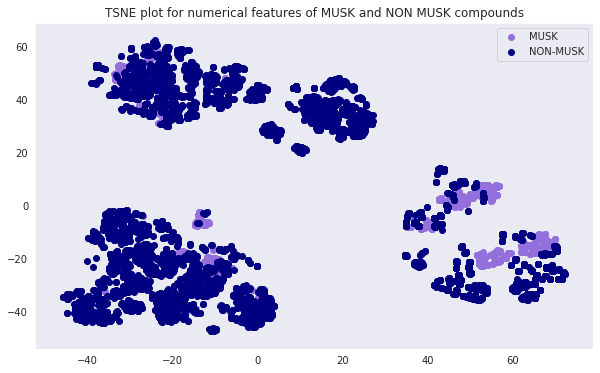

In [23]:
Musk = [i for i,j in zip(X_embedding, class_) if j==1]
Non_musk = [i for i,j in zip(X_embedding, class_) if j==0]
colors = {0:'navy', 1:'mediumpurple', 2:'green'}
plt.figure(figsize=(10,6))
plt.scatter([i[0] for i in Musk], [i[1] for i in Musk], c='mediumpurple',label='MUSK')
plt.scatter([i[0] for i in Non_musk], [i[1] for i in Non_musk], c='navy',label='NON-MUSK')
plt.legend()
plt.grid()
plt.title('TSNE plot for numerical features of MUSK and NON MUSK compounds')
plt.show()

    In the above two TSNE plot we can see that both plots have the overlaping MUSK and NON MUSK compounds. Therefore we need 
    to test the data with both normalized and without normalization to know if which gives better performance with our model.

    Dividing data into train, cross validation and test sets

In [0]:
X_train, X_cv, Y_train, Y_cv = train_test_split(numeric_features, class_, test_size=0.2)     # for numeric features without normalization
X_train_n, X_cv_n, Y_train_n, Y_cv_n = train_test_split(normalized_features, class_, test_size=0.2)         # for numeric features with nomalization

In [0]:
class roc_callback(keras.callbacks.Callback):
    def __init__(self,training_data,validation_data):
        
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
 
    def on_epoch_end(self, epoch, logs={}):        
        y_pred = self.model.predict(self.x)
        y_train = []
        y_pred_train = []
        for i in range(len(y_pred)):
            y_pred_train.append(y_pred[i][1])
            y_train.append(self.y[i][1])
        roc = roc_auc_score(y_train, y_pred_train)
        
        y_pred_val = self.model.predict(self.x_val)
        y_cv=[]
        y_pred_cv = []
        for i in range(len(y_pred_val)):
            y_pred_cv.append(y_pred_val[i][1])
            y_cv.append(self.y_val[i][1]) 
        roc_val = roc_auc_score(y_cv, y_pred_cv)   
        
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

In [0]:
def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        predictions.append(1 if i>=threshold else 0)
    return predictions

def precision(arr):
    arr = arr.astype(float)
    for i in range(2):
        x = arr[0][i]+arr[1][i]
        arr[0][i] = arr[0][i]/x
        arr[1][i] = arr[1][i]/x
    return arr
def recall(arr):
    arr = arr.astype(float)
    for i in range(2):
        x = arr[i][0]+arr[i][1]
        arr[i][0] = float(arr[i][0]/x)
        arr[i][1] = float(arr[i][1]/x)
    return arr
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

In [0]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

In [0]:
def confussion_matrix(pred, actual, t ):
    # https://datatofish.com/confusion-matrix-python/
    d = {'y_Predicted': pred,
         'y_Actual': actual
         }
    df = pd.DataFrame(d, columns=['y_Actual','y_Predicted'])
    a = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
    p = precision(np.array(a))
    p = pd.DataFrame(p, columns=['0', '1'])
    r = recall(np.array(a))
    r = pd.DataFrame(r, columns=['0', '1'])

    fig = plt.figure(figsize=(15,4))
    plt.subplot(1, 3, 1)
    ax = sns.heatmap(a,cbar=False, fmt='g', annot=True)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title('confusion matrix '+t)

    plt.subplot(1, 3, 2)
    df_corr = p.corr()
    ax = sns.heatmap(p,cbar=False, fmt='g', annot=True)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title('precision matrix '+t)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    plt.subplot(1, 3, 3)
    ax = sns.heatmap(r,cbar=False, fmt='g', annot=True)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title('recall matrix '+t)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    plt.close()

In [0]:
# one-hot-encoding the class category for softmax classification
y_train =  np.asarray(Y_train)
y_train = np_utils.to_categorical(y_train, 2)

y_cv = np.asarray(Y_cv)
y_cv = np_utils.to_categorical(y_cv, 2)

y_train_n =  np.asarray(Y_train_n)
y_train_n = np_utils.to_categorical(y_train_n, 2)

y_cv_n = np.asarray(Y_cv_n)
y_cv_n = np_utils.to_categorical(y_cv_n, 2)

### **Model** with **Multilayer** **perceptron**

In [0]:
start = Input(shape=(166))
layer = Dense(166, activation='relu')(start)
layer = Dropout(0.5)(layer)
layer = Dense(100, activation='relu')(layer)
layer = Dropout(0.5)(layer)
layer = Dense(50, activation='relu')(layer)
layer = Dropout(0.5)(layer)
layer = Dense(64, activation='relu')(layer)
layer = Dropout(0.5)(layer)
end = Dense(2, activation='softmax')(layer)

In [0]:
mlp_model = Model(start, end)
mlp_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    Model training and evaluation for numeric data without normalization

In [32]:
X_train = np.asarray(X_train)
X_cv = np.asarray(X_cv)
history_1 = mlp_model.fit(x = X_train, y=y_train, batch_size=100, epochs=10, validation_data=(X_cv, y_cv), 
                          callbacks=[roc_callback(training_data=[X_train, y_train],validation_data=[X_cv, y_cv] )])

Train on 5278 samples, validate on 1320 samples
Epoch 1/10
roc-auc: 0.8634 - roc-auc_val: 0.8488                                                                                                    
5278/5278 [==============================] - 2s 389us/sample - loss: 29.3944 - accuracy: 0.7171 - val_loss: 1.0929 - val_accuracy: 0.8780
Epoch 2/10
roc-auc: 0.8691 - roc-auc_val: 0.8523                                                                                                    
5278/5278 [==============================] - 1s 104us/sample - loss: 7.4272 - accuracy: 0.7431 - val_loss: 0.4867 - val_accuracy: 0.8674
Epoch 3/10
roc-auc: 0.8607 - roc-auc_val: 0.8408                                                                                                    
5278/5278 [==============================] - 1s 101us/sample - loss: 3.6329 - accuracy: 0.7681 - val_loss: 0.3283 - val_accuracy: 0.8697
Epoch 4/10
roc-auc: 0.8753 - roc-auc_val: 0.8686                                             

validation score: 0.2732289824521903
validation accuracy: 0.8651515


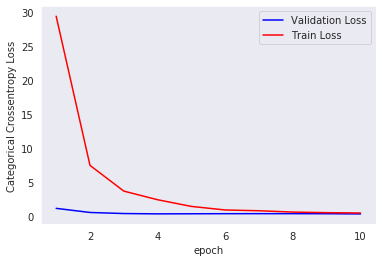

In [33]:
score = mlp_model.evaluate(X_cv, y_cv, verbose=0) # getting model scores
print('validation score:', score[0])
print('validation accuracy:', score[1])
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') 
ax.set_ylabel('Categorical Crossentropy Loss')
# list of epoch numbers
x = list(range(1,10+1))
vy = history_1.history['val_loss']
ty = history_1.history['loss']
plt_dynamic(x, vy, ty, ax)

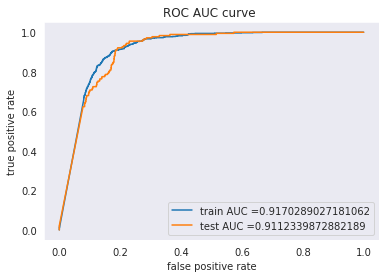

In [34]:
y_train_pred = list(mlp_model.predict(X_train, batch_size=100))
y_cv_pred = list(mlp_model.predict(X_cv))
tr = []
cv = []
tr_pr = []
cv_pr = []
for i in range(len(y_train_pred)):
    tr_pr.append(y_train_pred[i][1])
    tr.append(y_train[i][1])
for i in range(len(y_cv_pred)):
    cv_pr.append(y_cv_pred[i][1])
    cv.append(y_cv[i][1])
train_fpr, train_tpr, tr_thresholds = roc_curve(tr, tr_pr)
test_fpr, test_tpr, test_thresholds = roc_curve(cv, cv_pr)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC AUC curve ")
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr) 0.7459265729242995 for threshold 0.342


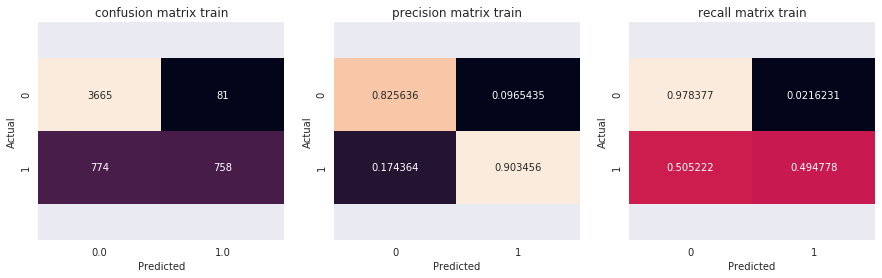

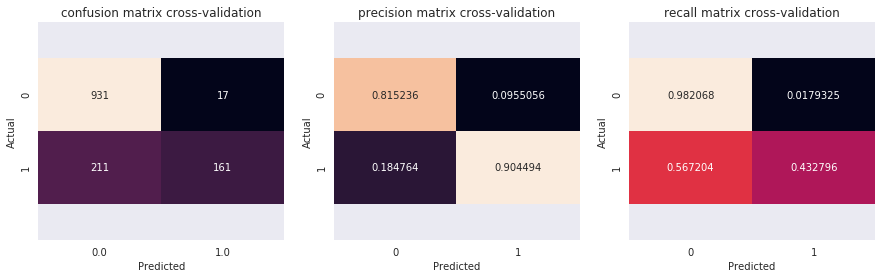

In [35]:
predicted = (mlp_model.predict(X_train, batch_size=100)).tolist()
predicted = [i[1] for i in predicted]
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
pred = predict_with_best_t(predicted, best_t)
confussion_matrix(tr, pred, 'train')

predicted = (mlp_model.predict(X_cv, batch_size=100)).tolist()
predicted = [i[1] for i in predicted]
pred = predict_with_best_t(predicted, best_t)
confussion_matrix(list(cv), pred, 'cross-validation')

    Model training and evaluation for data with normalization

In [0]:
mlp_model2 = Model(start, end)
mlp_model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [39]:
history_2 = mlp_model2.fit(x = X_train_n, y=y_train_n, batch_size=100, epochs=10, validation_data=(X_cv_n, y_cv_n), 
                          callbacks=[roc_callback(training_data=[X_train_n, y_train_n],validation_data=[X_cv_n, y_cv_n] )])

Train on 5278 samples, validate on 1320 samples
Epoch 1/10
roc-auc: 0.8635 - roc-auc_val: 0.862                                                                                                    
5278/5278 [==============================] - 1s 140us/sample - loss: 0.4360 - accuracy: 0.8444 - val_loss: 0.3772 - val_accuracy: 0.8508
Epoch 2/10
roc-auc: 0.9247 - roc-auc_val: 0.9238                                                                                                    
5278/5278 [==============================] - 0s 85us/sample - loss: 0.3335 - accuracy: 0.8446 - val_loss: 0.3130 - val_accuracy: 0.8508
Epoch 3/10
roc-auc: 0.9605 - roc-auc_val: 0.9605                                                                                                    
5278/5278 [==============================] - 0s 83us/sample - loss: 0.2818 - accuracy: 0.8446 - val_loss: 0.2505 - val_accuracy: 0.8508
Epoch 4/10
roc-auc: 0.9757 - roc-auc_val: 0.9769                                                 

validation score: 0.13401880851297668
validation accuracy: 0.9651515


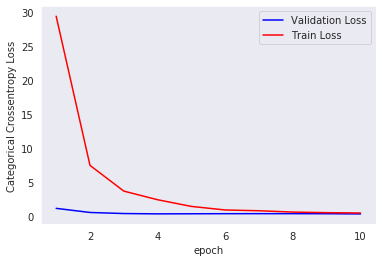

In [41]:
score = mlp_model2.evaluate(X_cv_n, y_cv_n, verbose=0) # getting model scores
print('validation score:', score[0])
print('validation accuracy:', score[1])
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') 
ax.set_ylabel('Categorical Crossentropy Loss')
# list of epoch numbers
x = list(range(1,10+1))
vy = history_1.history['val_loss']
ty = history_1.history['loss']
plt_dynamic(x, vy, ty, ax)

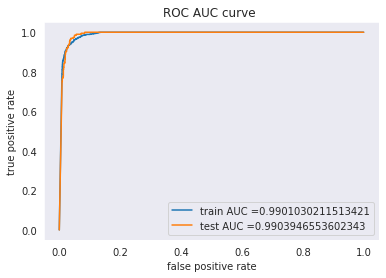

In [42]:
y_train_pred = list(mlp_model2.predict(X_train_n, batch_size=100))
y_cv_pred = list(mlp_model2.predict(X_cv_n))
tr = []
cv = []
tr_pr = []
cv_pr = []
for i in range(len(y_train_pred)):
    tr_pr.append(y_train_pred[i][1])
    tr.append(y_train_n[i][1])
for i in range(len(y_cv_pred)):
    cv_pr.append(y_cv_pred[i][1])
    cv.append(y_cv_n[i][1])
train_fpr, train_tpr, tr_thresholds = roc_curve(tr, tr_pr)
test_fpr, test_tpr, test_thresholds = roc_curve(cv, cv_pr)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC AUC curve ")
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr) 0.9150608935429866 for threshold 0.33


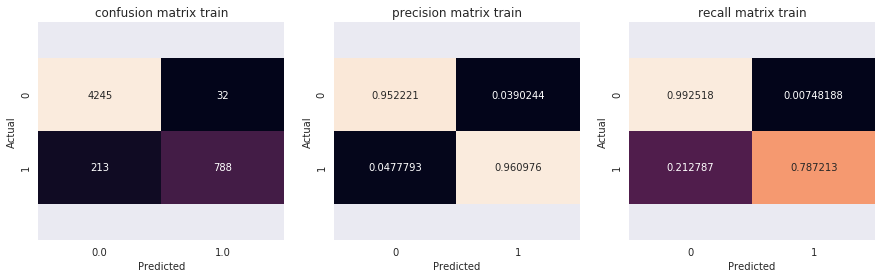

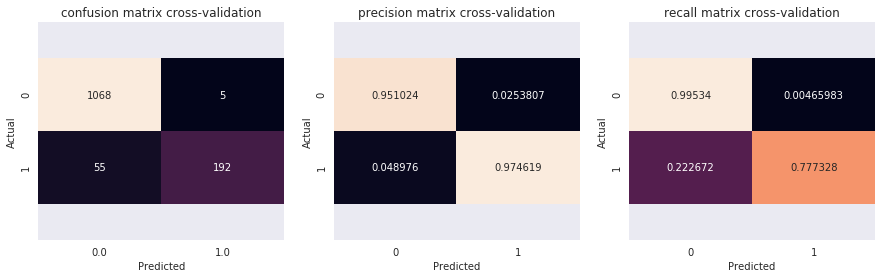

In [43]:
predicted = (mlp_model2.predict(X_train_n, batch_size=100)).tolist()
predicted = [i[1] for i in predicted]
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
pred = predict_with_best_t(predicted, best_t)
confussion_matrix(tr, pred, 'train')

predicted = (mlp_model2.predict(X_cv_n, batch_size=100)).tolist()
predicted = [i[1] for i in predicted]
pred = predict_with_best_t(predicted, best_t)
confussion_matrix(list(cv), pred, 'cross-validation')

### **Summary** of Multilayer perceptron model

*   The validation score and auc is better for the data with normalization
*   The precision and recall is also better for the data with normalization.



## **Model** with 1D **convolution** **layer**

In [0]:
X_train = np.expand_dims(X_train, axis=2).astype(float)
X_cv = np.expand_dims(X_cv, axis=2).astype(float)
X_train_n = np.expand_dims(X_train_n, axis=2).astype(float)
X_cv_n = np.expand_dims(X_cv_n, axis=2).astype(float)

In [0]:
start = Input(shape=(166,1))
layer = Conv1D(32, 4, padding='same')(start)
layer = Flatten()(layer)
layer = Dense(128, activation='relu')(layer)
layer = Dense(64, activation='relu')(layer)
end = Dense(2, activation='softmax')(layer)

In [0]:
conv_model = Model(start, end)
conv_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [47]:
history_1 = conv_model.fit(x = X_train, y=y_train, batch_size=100, epochs=15, validation_data=(X_cv, y_cv), 
                          callbacks=[roc_callback(training_data=[X_train, y_train],validation_data=[X_cv, y_cv] )])

Train on 5278 samples, validate on 1320 samples
Epoch 1/15
roc-auc: 0.9614 - roc-auc_val: 0.9478                                                                                                    
5278/5278 [==============================] - 4s 684us/sample - loss: 4.0230 - accuracy: 0.8696 - val_loss: 0.5108 - val_accuracy: 0.9227
Epoch 2/15
roc-auc: 0.9824 - roc-auc_val: 0.9721                                                                                                    
5278/5278 [==============================] - 1s 106us/sample - loss: 0.5921 - accuracy: 0.9290 - val_loss: 0.5421 - val_accuracy: 0.9417
Epoch 3/15
roc-auc: 0.9893 - roc-auc_val: 0.9835                                                                                                    
5278/5278 [==============================] - 1s 104us/sample - loss: 0.3081 - accuracy: 0.9460 - val_loss: 0.2049 - val_accuracy: 0.9674
Epoch 4/15
roc-auc: 0.9942 - roc-auc_val: 0.9901                                              

validation score: 0.06765028971236792
validation accuracy: 0.9757576


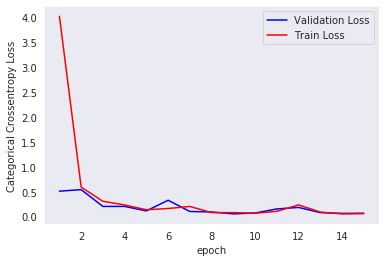

In [48]:
score = conv_model.evaluate(X_cv, y_cv, verbose=0) # getting model scores
print('validation score:', score[0])
print('validation accuracy:', score[1])
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') 
ax.set_ylabel('Categorical Crossentropy Loss')
# list of epoch numbers
x = list(range(1,15+1))
vy = history_1.history['val_loss']
ty = history_1.history['loss']
plt_dynamic(x, vy, ty, ax)

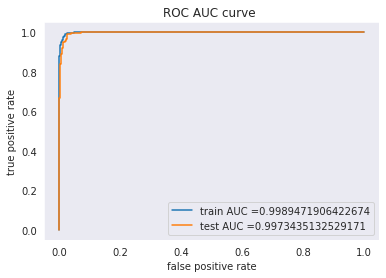

In [49]:
y_train_pred = list(conv_model.predict(X_train, batch_size=1000))
y_cv_pred = list(conv_model.predict(X_cv))
tr = []
cv = []
tr_pr = []
cv_pr = []
for i in range(len(y_train_pred)):
    tr_pr.append(y_train_pred[i][1])
    tr.append(y_train[i][1])
for i in range(len(y_cv_pred)):
    cv_pr.append(y_cv_pred[i][1])
    cv.append(y_cv[i][1])
train_fpr, train_tpr, tr_thresholds = roc_curve(tr, tr_pr)
test_fpr, test_tpr, test_thresholds = roc_curve(cv, cv_pr)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC AUC curve ")
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr) 0.9707756125210475 for threshold 0.013


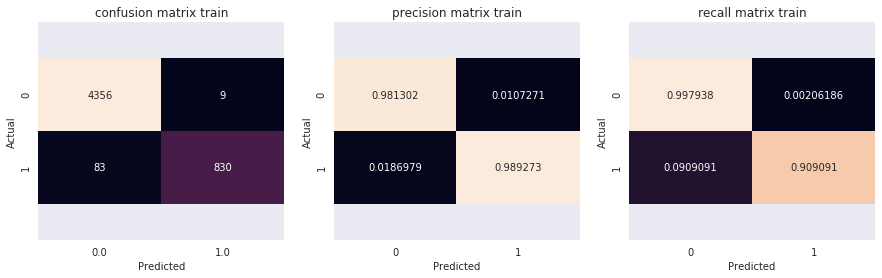

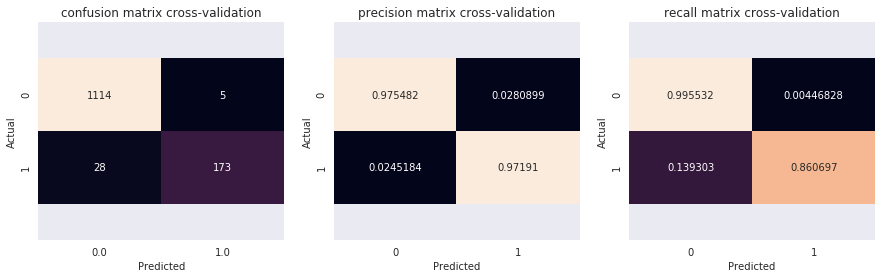

In [50]:
predicted = (conv_model.predict(X_train, batch_size=100)).tolist()
predicted = [i[1] for i in predicted]
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
pred = predict_with_best_t(predicted, best_t)
confussion_matrix(tr, pred, 'train')

predicted = (conv_model.predict(X_cv, batch_size=100)).tolist()
predicted = [i[1] for i in predicted]
pred = predict_with_best_t(predicted, best_t)
confussion_matrix(list(cv), pred, 'cross-validation')

In [0]:
conv_model2 = Model(start, end)
conv_model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [53]:
history_2 = conv_model2.fit(x = X_train_n, y=y_train_n, batch_size=100, epochs=15, validation_data=(X_cv_n, y_cv_n), 
                          callbacks=[roc_callback(training_data=[X_train_n, y_train_n],validation_data=[X_cv_n, y_cv_n] )])

Train on 5278 samples, validate on 1320 samples
Epoch 1/15
roc-auc: 0.9381 - roc-auc_val: 0.9331                                                                                                    
5278/5278 [==============================] - 1s 103us/sample - loss: 0.3335 - accuracy: 0.8554 - val_loss: 0.2140 - val_accuracy: 0.9273
Epoch 2/15
roc-auc: 0.9867 - roc-auc_val: 0.9878                                                                                                    
5278/5278 [==============================] - 1s 102us/sample - loss: 0.1617 - accuracy: 0.9367 - val_loss: 0.1103 - val_accuracy: 0.9598
Epoch 3/15
roc-auc: 0.9887 - roc-auc_val: 0.988                                                                                                    
5278/5278 [==============================] - 1s 147us/sample - loss: 0.1040 - accuracy: 0.9610 - val_loss: 0.0917 - val_accuracy: 0.9606
Epoch 4/15
roc-auc: 0.996 - roc-auc_val: 0.9959                                                

validation score: 0.022216798856654597
validation accuracy: 0.9909091


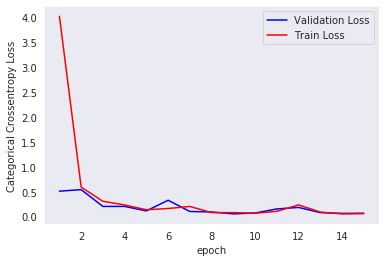

In [55]:
score = conv_model.evaluate(X_cv_n, y_cv_n, verbose=0) # getting model scores
print('validation score:', score[0])
print('validation accuracy:', score[1])
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') 
ax.set_ylabel('Categorical Crossentropy Loss')
# list of epoch numbers
x = list(range(1,15+1))
vy = history_1.history['val_loss']
ty = history_1.history['loss']
plt_dynamic(x, vy, ty, ax)

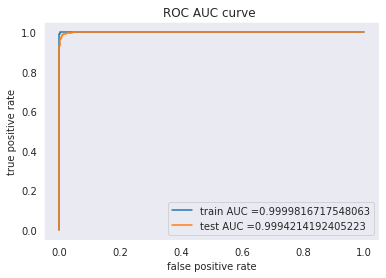

In [56]:
y_train_pred = list(conv_model.predict(X_train_n, batch_size=1000))
y_cv_pred = list(conv_model.predict(X_cv_n))
tr = []
cv = []
tr_pr = []
cv_pr = []
for i in range(len(y_train_pred)):
    tr_pr.append(y_train_pred[i][1])
    tr.append(y_train_n[i][1])
for i in range(len(y_cv_pred)):
    cv_pr.append(y_cv_pred[i][1])
    cv.append(y_cv_n[i][1])
train_fpr, train_tpr, tr_thresholds = roc_curve(tr, tr_pr)
test_fpr, test_tpr, test_thresholds = roc_curve(cv, cv_pr)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC AUC curve ")
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr) 0.9974362341200801 for threshold 0.224


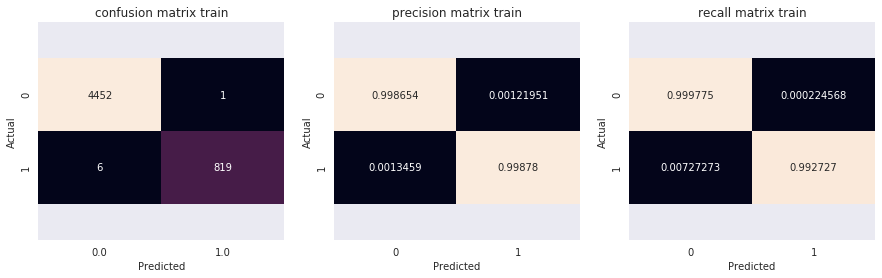

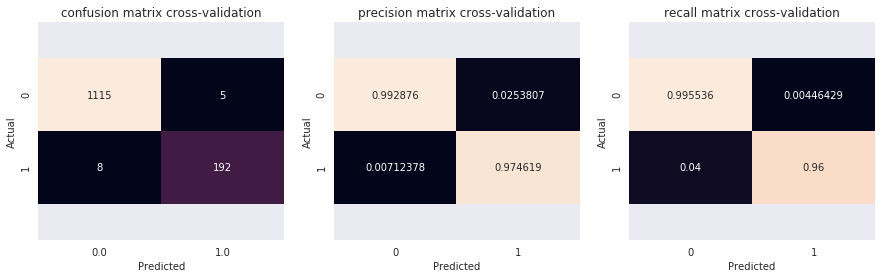

In [57]:
predicted = (conv_model.predict(X_train_n, batch_size=100)).tolist()
predicted = [i[1] for i in predicted]
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
pred = predict_with_best_t(predicted, best_t)
confussion_matrix(tr, pred, 'train')

predicted = (conv_model.predict(X_cv_n, batch_size=100)).tolist()
predicted = [i[1] for i in predicted]
pred = predict_with_best_t(predicted, best_t)
confussion_matrix(list(cv), pred, 'cross-validation')

### **Summary** for **Convolution** model

*   In the convolution model also the validation and auc score is better for the data with normalization
*   The precision and recall is also better for data with normalization



# **Conclusion**

*   In b/w the above models and the model with convolution layer and normalized data performes better as the validation score, roc-auc score, precision and recall all the performance metrics are better than others.

